### Imports

In [1]:
!pip install -r requirements.txt

ERROR: Could not find a version that satisfies the requirement apsw==3.33.0.post1
ERROR: No matching distribution found for apsw==3.33.0.post1


In [ ]:
!pip install matplotlib pandas profilehooks scikit-learn torchvision

In [44]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import copy
import os

from torchvision.datasets import MNIST

from profilehooks import profile
    
import matplotlib.pylab as plt

#### Get number of threads and choose range of number of clusters

In [46]:
N_PROC = 2 #CHANGE THIS
N_TREES = 1000
N_TRAIN_CYCLES = 2

### Workload

Run a random forest classifier on the MNIST dataset. The training process is CPU only with the trees distributed across N_PROC. Note: obviously, we are not claiming a random forest classifier is the most appropriate model for an image classification problem on raw pixel features.

In [47]:
data = MNIST('./', download=True)

In [48]:
data.train_labels

/home/sanjay/venv_general/lib64/python3.8/site-packages/torchvision/datasets/mnist.py:48: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


tensor([5, 0, 4,  ..., 5, 6, 8])

In [49]:
#flatten each image
data_features = data.train_data.numpy().reshape(data.train_data.shape[0], -1).astype(np.float32)
data_labels = data.train_labels.numpy()
print(data_features.shape)
print(data_labels.shape)

(60000, 784)
(60000,)


/home/sanjay/venv_general/lib64/python3.8/site-packages/torchvision/datasets/mnist.py:58: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


In [50]:
model = RandomForestClassifier(n_estimators = N_TREES,
                               max_depth =15,
                               n_jobs = N_PROC,
                               oob_score = True)

### Some run times

In [51]:
@profile(immediate=True)
def train(data_features, data_labels, N_TRAIN_CYCLES):
    scores = []
    
    for _ in range(N_TRAIN_CYCLES):
        model = RandomForestClassifier(n_estimators = N_TREES,
                               max_depth =15,
                               n_jobs = N_PROC,
                               oob_score = True)
        
        model.fit(data_features, data_labels)
        
        scores.append(model.oob_score_)
    
    return scores

In [53]:
scores = train(data_features, data_labels, N_TRAIN_CYCLES)


*** PROFILER RESULTS ***
train (<ipython-input-51-0270da01e5ef>:1)
function called 1 times

         3120430 function calls (3064420 primitive calls) in 283.600 seconds

   Ordered by: cumulative time, internal time, call count
   List reduced from 370 to 40 due to restriction <40>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.019    0.019  283.600  283.600 <ipython-input-51-0270da01e5ef>:1(train)
        2    0.000    0.000  283.581  141.790 _forest.py:273(fit)
        2    0.000    0.000  248.368  124.184 parallel.py:958(__call__)
        2    0.017    0.009  248.364  124.182 parallel.py:918(retrieve)
     2000    0.004    0.000  248.343    0.124 pool.py:764(get)
     2000    0.003    0.000  248.336    0.124 pool.py:761(wait)
     2010    0.007    0.000  248.334    0.124 threading.py:540(wait)
     1976    0.012    0.000  248.323    0.126 threading.py:270(wait)
     7928  248.306    0.031  248.306    0.031 {method 'acquire' of '_thread.lock'

(array([1., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([0.96683333, 0.96687   , 0.96690667, 0.96694333, 0.96698   ,
        0.96701667, 0.96705333, 0.96709   , 0.96712667, 0.96716333,
        0.9672    ]),
 <BarContainer object of 10 artists>)

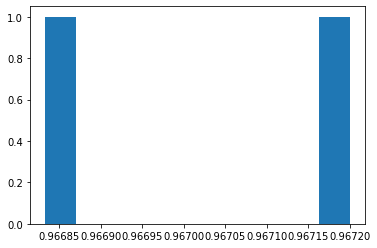

In [54]:
plt.hist(scores)